# Código em OpenMP
Para implementar a versão OpenMP do programa do cálculo do conjunto de Mandelbrot tivemos que remover a alocação de memória e comandos de leitura e escrita do códgio fornecido previamente.
Como não há comandos de leitura, os comandos de leitura e escrita são retirados, removendo-se a função ```write_to_file()```. No caso de alocação de memória pode ser que o tempo de acesso a um vetor possa ser relevante, portanto não simplesmente removemos a função de alocação de memória. Para retirar as alocações, supomos que o tamanho máximo de uma imagem será de 11500px x 11500px e assim substituimos a alocação dinâmica do \code{image\_buffer} por uma alocação estática: ```char image_buffer[11500*11500][3]```.

Para paralelizar o cálculo, como esperado do OpenMP, é tão fácil como adicionar um ```\#pragma``` antes do ```for``` que realiza o cálculo para cada pixel da imagem:
```c
    #pragma omp parallel for private(...) num_threads(nThreads) schedule(dynamic)
    for (i_y = 0; i_y < i_y_max; i_y++) {
        c_y = c_y_min + i_y * pixel_height;
        ...
```
Implementando dessa forma obtemos os seguintes resultados:

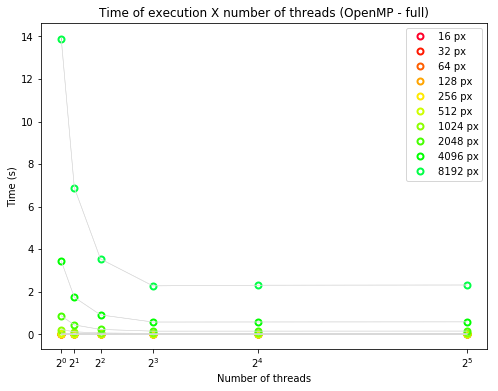

In [1]:
import warnings
warnings.filterwarnings('ignore')
%run omp_graph.py
%matplotlib inline
# %pylab inline
# pylab.rcParams['figure.figsize'] = (14, 8)
import mpld3
mpld3.enable_notebook()

file_path = "for_duplo/"
results = parse_parallel_results(file_path)
plot = Plotter()
plot.timeXthread(results, "full")

Esse gráfico mostra o tempo de execução X numero de threads para cada tamanho de entrada. Esses valores foram experimentados na região "full". Barras de erro também estão plotadas, porém são tão pequenas que talvez não estejam visiveis.

Percebemos que o aumento de threads de fato melhorou o tempo de execução do programa. No entanto ao ultrapassar 8, o mesmo número de cores da maquina testada, não houve grande melhora no tempo de execução. Esse mesmo comportamento foi observado para as demais regiões:

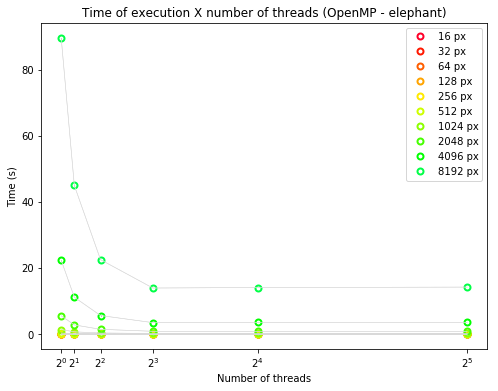

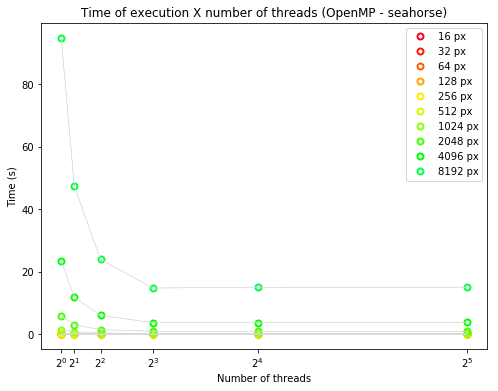

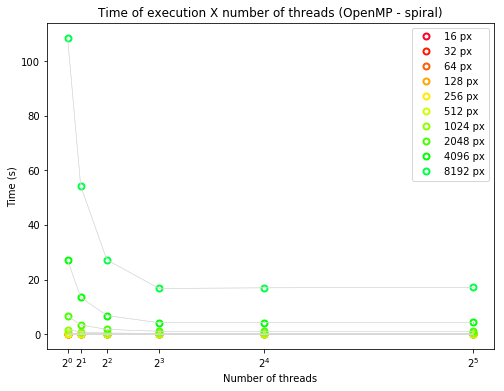

In [2]:
import warnings
warnings.filterwarnings('ignore')
%run omp_graph.py
%matplotlib inline
# %pylab inline
# pylab.rcParams['figure.figsize'] = (14, 8)
import mpld3
mpld3.enable_notebook()

file_path = "for_duplo/"
results = parse_parallel_results(file_path)

for reg in ["elephant", "seahorse", "spiral"]:
    plot = Plotter()
    plot.timeXthread(results, reg)

Nota-se que nessas regiões apesar do comportamento do tempo X numero de threads manter-se o mesmo, o tempo de execução aumenta, pois nessas regiões há mais cálculos de pontos com mais interações. Podemos comparar todas as regiões:

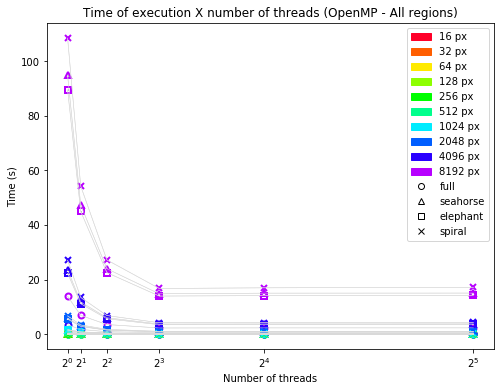

In [3]:
import warnings
warnings.filterwarnings('ignore')
%run omp_graph.py
%matplotlib inline
# %pylab inline
# pylab.rcParams['figure.figsize'] = (14, 8)
import mpld3
mpld3.enable_notebook()

file_path = "for_duplo/"
results = parse_parallel_results(file_path)
plot = Plotter()
plot.all_timeXthread(results)

Vemos que as regiões Spiral, Seahorse e Elephant tem tempo de execução bastante maior que a região Full.

Em todos esses gráficos também vemos que quanto maior o tamanho da entrada, mais tempo o programa leva para ser executado. Porém também queremos saber qual é a relação entre tamanho de entrada e o tempo:

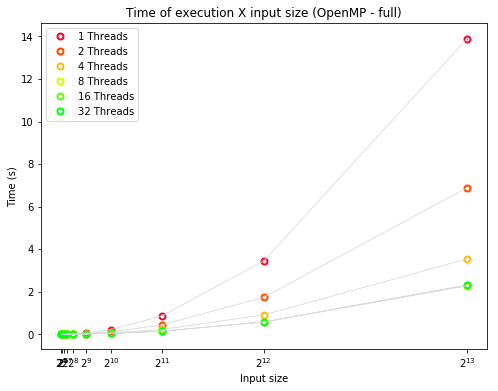

In [4]:
import warnings
warnings.filterwarnings('ignore')
%run omp_graph.py
%matplotlib inline
# %pylab inline
# pylab.rcParams['figure.figsize'] = (14, 8)
import mpld3
mpld3.enable_notebook()

file_path = "for_duplo/"
results = parse_parallel_results(file_path)
plot = Plotter()
plot.timeXsize(results, "full")

Vemos que há um aumento exponencial do tempo pelo tamanho da imagem. Vale lembrar que consideramos o tamanho de entrada, somente o tamanho do lado da imagem, portanto o comportamento exponencial se justifica por o número de pixels (chamadas para a função ```compute_manderbolt()``` ser o tamanho do lado da imagem elevado ao quadrado.

Nas demais regiões o comportamento é semelhante:

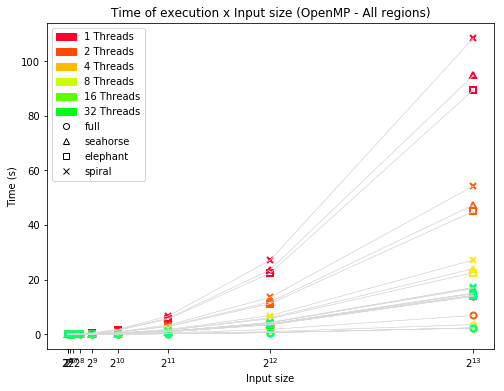

In [5]:
import warnings
warnings.filterwarnings('ignore')
%run omp_graph.py
%matplotlib inline
# %pylab inline
# pylab.rcParams['figure.figsize'] = (14, 8)
import mpld3
mpld3.enable_notebook()

file_path = "for_duplo/"
results = parse_parallel_results(file_path)
plot = Plotter()
plot.all_timeXsize(results)

## Implementação com 1 for

Após realizar esses primeiros testes imaginamos que se paralelizassemos o for de dentro o programa pudesse ficar mais rápido. Para fazer isso como eram dois fors simples, decidimos transforma-los em um só:
```c
    #pragma omp parallel for private(...) num_threads(nThreads) schedule(dynamic)
    for (i = 0; i < i_y_max * i_x_max; i++) {
        i_y = i / i_y_max;
        i_x = i % i_y_max;
        ...
```
Com essa implementação e usando ```schedule(dynamic)```, ou seja com o chunk de tamanho 1, obtivemos os seguintes resultados:

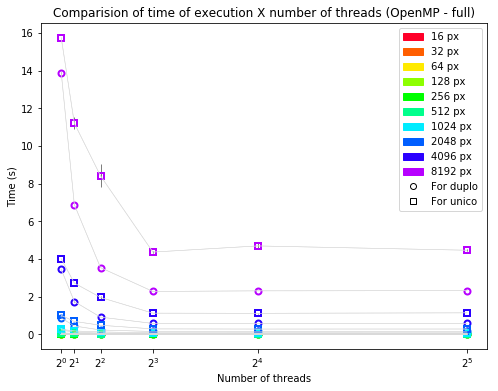

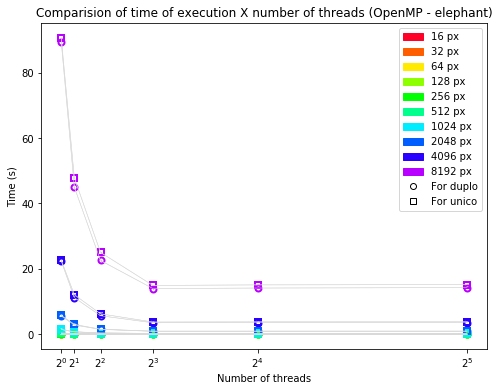

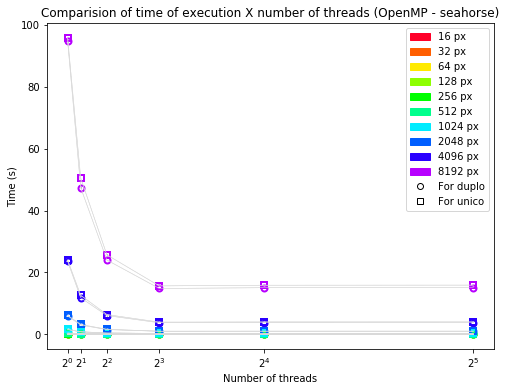

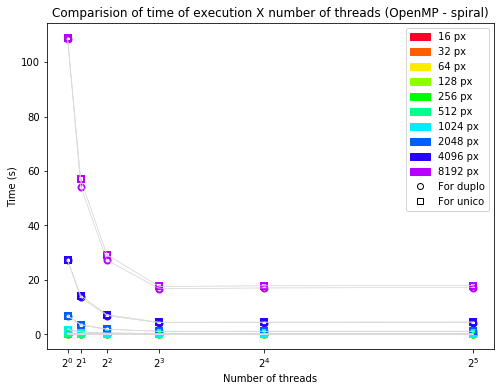

In [6]:
import warnings
warnings.filterwarnings('ignore')
%run omp_graph.py
%matplotlib inline
# %pylab inline
# pylab.rcParams['figure.figsize'] = (14, 8)
import mpld3
mpld3.enable_notebook()

file_path = "for_duplo/"
file_path2 = "for_unico/"
results = parse_parallel_results(file_path)
results2 = parse_parallel_results(file_path2)
for reg in ["full", "elephant", "seahorse", "spiral"]:
    plot = Plotter()
    plot.compare_timeXthread(results, results2, reg, group1="For duplo", group2="For unico")

Para o caso da região full nota-se que em todos os casos a versão com dois fors foi mais rápida que a versão com somente um. Apesar do gráfico da região Full parecer que há mais variação também devemos lembrar que o eixo Y dela vai de 0 a 16, enquanto os demais ultrapassam 80. Se verificarmos as diferenças entre tempos com o mesmo número de threads, haverá sempre uma diferença semelhante em todas as regiões.
Como talvez o problema sejam os chunks sejam muito pequenos e por conta disso o programa gaste muito tempo fazendo troca de contexto, o próximo experimento foi feito com chunks maiores. Dividimos o número de interações do for pelo número de threads, isto é, cada thread terá um chunk para sí:

```c
    #pragma omp parallel for private(...) num_threads(nThreads) schedule(dynamic, i_y_max * i_x_max / nThreads)
    for (i = 0; i < i_y_max * i_x_max; i++) {
        i_y = i / i_y_max;
        i_x = i % i_y_max;
        ...
```

No entanto os resultados ainda foram piores do que o for duplo com ```schedule(dynamic)```:

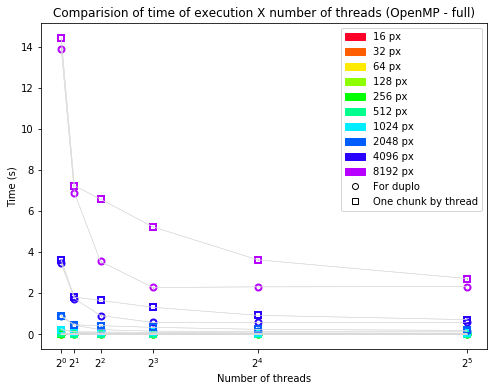

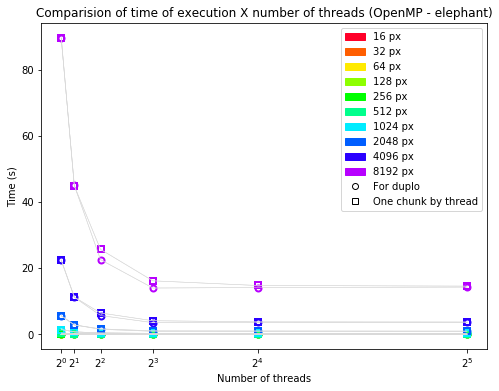

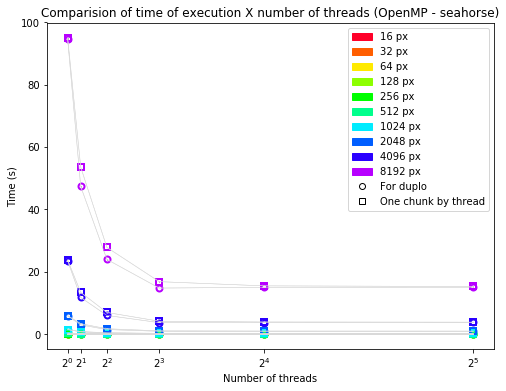

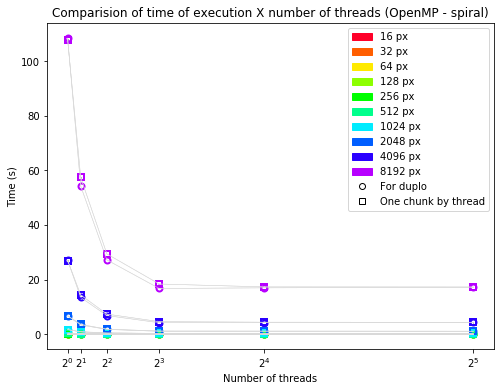

In [7]:
import warnings
warnings.filterwarnings('ignore')
%run omp_graph.py
%matplotlib inline
# %pylab inline
# pylab.rcParams['figure.figsize'] = (14, 8)
import mpld3
mpld3.enable_notebook()

file_path = "for_duplo/"
file_path2 = "dynamic_bigbig/"
results = parse_parallel_results(file_path)
results2 = parse_parallel_results(file_path2)
for reg in ["full", "elephant", "seahorse", "spiral"]:
    plot = Plotter()
    plot.compare_timeXthread(results, results2, reg, group1="For duplo", group2="One chunk by thread")

Nesse caso como temos um chunk por thread, caso esse seja um chunk onde haja computações mais complexas que os demais, é provavel que as demais threads terminem antes e somente uma fique processando. Nesse cenário, haveria disperdicio dos recursos do computador e por isso a implementação com 2 fors, que divide os chunks em tamanhos menores, teve resultados com menor tempo de execução.

## Dynamic vs Static
Realizamos também testes entre ```schedule(dynamic)``` e ```schedule(static)```. Para cada um deles comparamos 3 tamanhos de chunk: chunks de tamanho 1, chunks de tamanho igual ao tamanho de entrada (lado da imagem) e chunks de tamanho tal que haja um chunk por thread ($tamanho\_entrada^2 / nThreads$)

Para chunks de tamanho tal que haja um chunk por thread, notamos que a implementação estatica e dinâmica executam em tempos quase identicos:

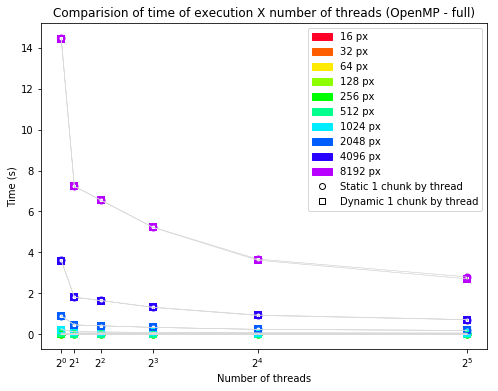

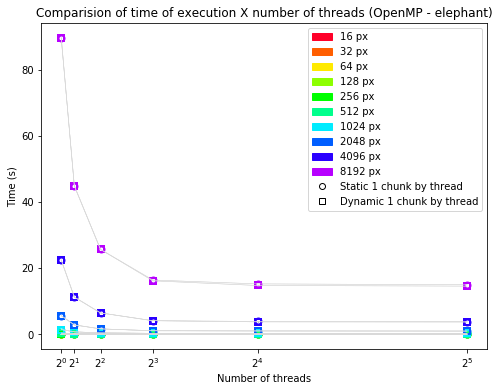

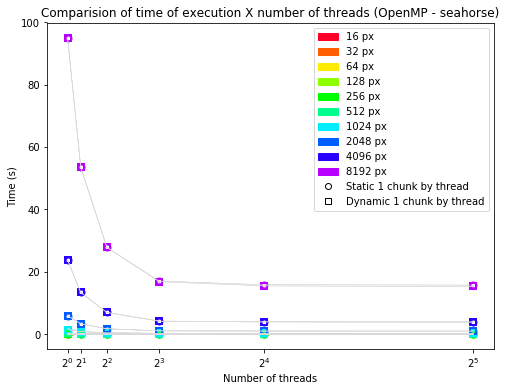

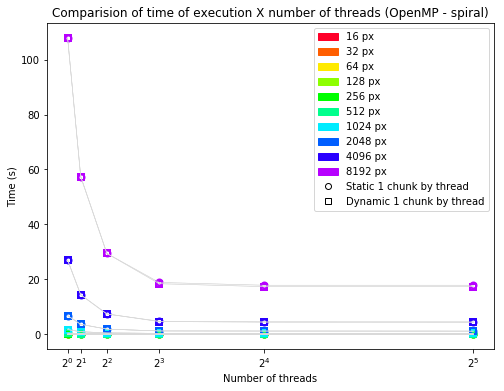

In [8]:
import warnings
warnings.filterwarnings('ignore')
%run omp_graph.py
%matplotlib inline
# %pylab inline
# pylab.rcParams['figure.figsize'] = (14, 8)
import mpld3
mpld3.enable_notebook()

file_path = "static_bigbig/"
file_path2 = "dynamic_bigbig/"
results = parse_parallel_results(file_path)
results2 = parse_parallel_results(file_path2)
for reg in ["full", "elephant", "seahorse", "spiral"]:
    plot = Plotter()
    plot.compare_timeXthread(results, results2, reg, group1="Static 1 chunk by thread", group2="Dynamic 1 chunk by thread")
    
    

Para chunks de tamanho igual ao tamanho de entrada, também notamos que as implementações estatica e dinâmcia executam em tempo bastante semelhantes:

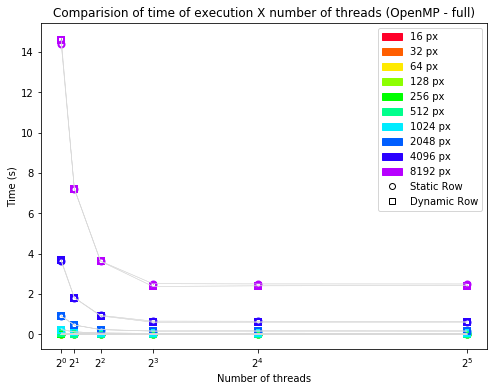

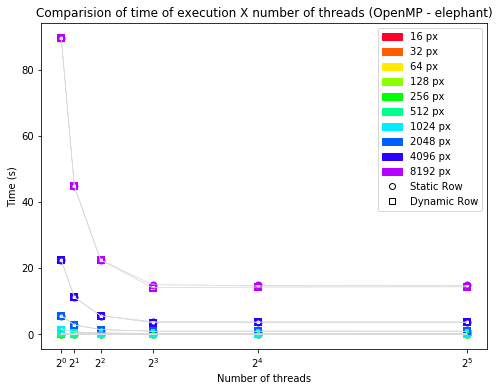

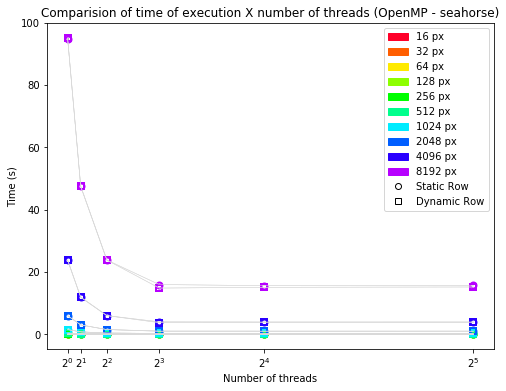

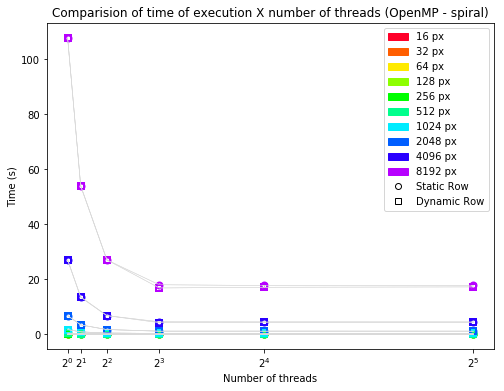

In [10]:
import warnings
warnings.filterwarnings('ignore')
%run omp_graph.py
%matplotlib inline
# %pylab inline
# pylab.rcParams['figure.figsize'] = (14, 8)
import mpld3
mpld3.enable_notebook()

file_path = "static_row/"
file_path2 = "dynamic_row/"
results = parse_parallel_results(file_path)
results2 = parse_parallel_results(file_path2)
for reg in ["full", "elephant", "seahorse", "spiral"]:
    plot = Plotter()
    plot.compare_timeXthread(results, results2, reg, group1="Static Row", group2="Dynamic Row")
    
    

Para chunks de tamanho 1, obtivemos valores mais variados:

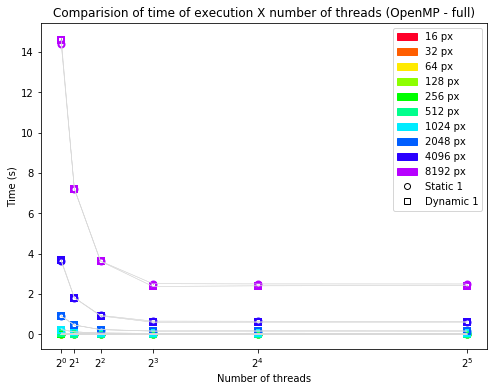

In [11]:
import warnings
warnings.filterwarnings('ignore')
%run omp_graph.py
%matplotlib inline
# %pylab inline
# pylab.rcParams['figure.figsize'] = (14, 8)
import mpld3
mpld3.enable_notebook()

file_path = "static_row/"
file_path2 = "dynamic_row/"
results = parse_parallel_results(file_path)
results2 = parse_parallel_results(file_path2)
for reg in ["full"]:
    plot = Plotter()
    plot.compare_timeXthread(results, results2, reg, group1="Static 1", group2="Dynamic 1")
    
    

Vemos que nesse caso a implementação estática se comportou melhor que a dinâmica. No entanto para regiões com mais pontos de muitas iterações do cálculo de mandelbrot notamos que para 4 e 8 threads a implementação dinâmica apresenta resultados menores que a estática:

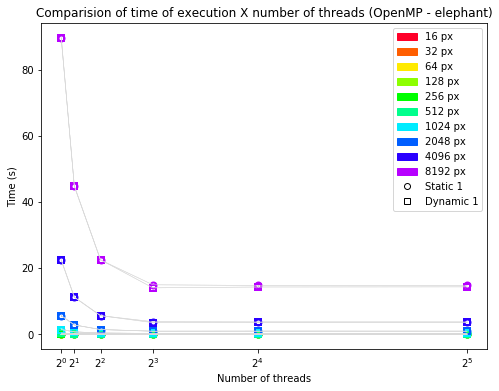

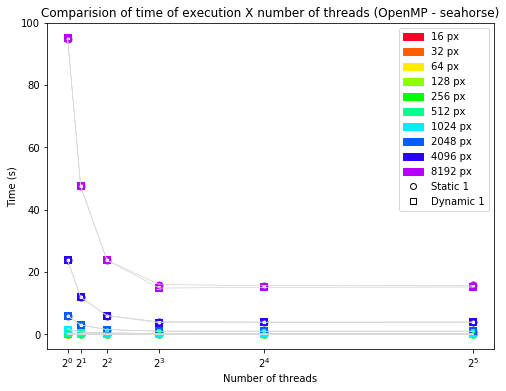

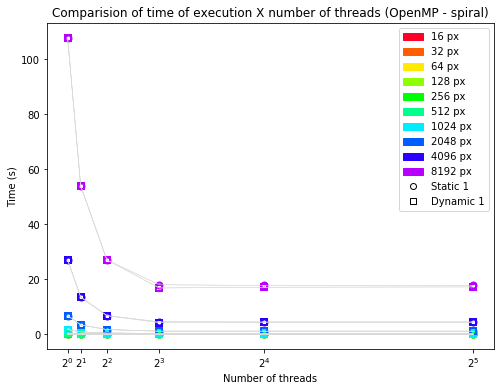

In [12]:
import warnings
warnings.filterwarnings('ignore')
%run omp_graph.py
%matplotlib inline
# %pylab inline
# pylab.rcParams['figure.figsize'] = (14, 8)
import mpld3
mpld3.enable_notebook()

file_path = "static_row/"
file_path2 = "dynamic_row/"
results = parse_parallel_results(file_path)
results2 = parse_parallel_results(file_path2)
for reg in ["elephant", "seahorse", "spiral"]:
    plot = Plotter()
    plot.compare_timeXthread(results, results2, reg, group1="Static 1", group2="Dynamic 1")
    
    